### First experiments with U-Net on CESM slp data

Trained model with **variable mask** and **augmentation factor 3** on samples with rel. amount of missing values in the **range of [0,1]**.

Use this single model to find the **optimized sampling strategy** in a brute-force manner.

In [1]:
import os
import sys
sys.path.append('../reconstruct_missing_data')

from pathlib import Path
from json import dump, load

import numpy as np
import pandas as pd
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from matplotlib import pyplot as plt

from data_loading import find_data_files, load_data_set, get_anomalies, clone_data, create_missing_mask, split_and_scale_data
from models import build_unet_4conv
from relevance import compute_single_relevance_map

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Lambda, concatenate, Conv1D, Conv2D, MaxPool2D, UpSampling2D, BatchNormalization, LeakyReLU
from tensorflow.keras.optimizers import Adam, SGD
import tensorflow.keras.initializers as tfi
import tensorflow.keras.regularizers as tfr
from tensorflow.keras.utils import plot_model

# Suppress Tensorflow warnings
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [2]:
# Set working directory, according to working directory in scripts:
# os.chdir('/gxfs_work1/geomar/smomw511') # nesh
os.chdir('/Users/mlandt-hayen') # local
# os.chdir('/work') # local in Docker Container

In [3]:
## Reload parameters and results for experiment:

# Specify experiment:
model_config = 'unet_4conv'
feature = 'sea-surface-temperature' # Choose either 'sea-level-pressure' or 'sea-surface-temperature' as feature.
feature_short = 'sst' # Free to set short name, to store results, e.g. 'slp' and 'sst'.
source = 'CESM' # Choose Earth System Model, either 'FOCI' or 'CESM'.
mask_type = 'variable'
missing_type = 'range_0_100'
augmentation_factor = 3
run = '_final'
exp_name = '/relevance_1'

# Get path to stored results:
path_to_stored_results = Path('GitGeomar/marco-landt-hayen/reconstruct_missing_data_results/'+model_config+'_'+feature_short+'_'+source+'_'
                      +mask_type+'_'+missing_type+'_factor_'+str(augmentation_factor)+run+exp_name)

print(path_to_stored_results)

# Reload parameters relevant for data pre-processing for this experiment:
with open(path_to_stored_results / 'parameters.json', 'r') as f:
    parameters=load(f)


train_val_split = parameters['train_val_split']
scale_to = parameters['scale_to']
n_samples = parameters['n_samples']
patch_size = parameters['patch_size']
max_patch_num = parameters['max_patch_num']
max_acc_rel_loss_reduction = parameters['max_acc_rel_loss_reduction']

# Print parameters:
print("\nnumber of samples: ", n_samples)
print("patch size: ", patch_size)
print("max. number of patches to include: ", max_patch_num)
print("max. acc. rel. loss as threshold: ", max_acc_rel_loss_reduction)

GitGeomar/marco-landt-hayen/reconstruct_missing_data_results/unet_4conv_sst_CESM_variable_range_0_100_factor_3_final/relevance_1

number of samples:  240
patch size:  1
max. number of patches to include:  50
max. acc. rel. loss as threshold:  0.9


In [15]:
# ## For the following individual list of samples:

# relevance_3_samples = [
#     0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,23,24,25,26,27,28,29,30,31,32,34,35,36,38,39,
#     40,41,42,44,45,47,48,49,50,51,52,53,54,55,56,57,58,59,9530,9531,9532,9533,9534,9535,9536,9537,9538,9539,
#     9540,9541,9542,9543,9544,9545,9546,9548,9549,9550,9551,9553,9554,9555,9556,9557,9558,9559,9560,9561,9562,
#     9563,9564,9565,9566,9567,9568,9569,9570,9571,9572,9573,9574,9575,9576,9577,9578,9579,9580,9581,9582,9583,
#     9584,9585,9586,9587,9588,9589
# ]

# # Combine results:
# for n in relevance_3_samples:

#     ## rel_loss_reduction_maps:
    
#     # Define filename, according to sample number.
#     # Reload result for sample.
#     # Concatenate result with all results.  
#     # Define filename for all samples.
#     # Save results for all samples.
#     file_name_rel_loss_reduction_map = "rel_loss_reduction_map_sample_"+str(n)+".npy"
#     rel_loss_reduction_map = np.load(path_to_stored_results / file_name_rel_loss_reduction_map)
#     # Initialize storage for sample 0:
#     if n == 0:
#         rel_loss_reduction_maps = np.expand_dims(rel_loss_reduction_map,axis=0)
#     else:
#         rel_loss_reduction_maps = np.concatenate([rel_loss_reduction_maps,np.expand_dims(rel_loss_reduction_map,axis=0)])
# file_name_rel_loss_reduction_maps = "rel_loss_reduction_maps.npy"
# np.save(path_to_stored_results / file_name_rel_loss_reduction_maps, rel_loss_reduction_maps)
    
# # Combine results:
# for n in relevance_3_samples:  

#     ## patch_orders:
    
#     # Define filename, according to sample number.
#     # Reload result for sample.
#     # Concatenate result with all results.  
#     # Define filename for all samples.
#     # Save results for all samples.
#     file_name_patch_order = "patch_order_sample_"+str(n)+".npy"
#     patch_order = np.load(path_to_stored_results / file_name_patch_order)
#     # Initialize storage for sample 0:
#     if n == 0:
#         patch_orders = np.expand_dims(patch_order,axis=0)
#     else:
#         patch_orders = np.concatenate([patch_orders,np.expand_dims(patch_order,axis=0)])
# file_name_patch_orders = "patch_orders.npy"
# np.save(path_to_stored_results / file_name_patch_orders, patch_orders)
     
# # Combine results:
# for n in relevance_3_samples:  

#     ## abs_loss_reduction:
    
#     # Define filename, according to sample number.
#     # Reload result for sample.
#     # Concatenate result with all results.  
#     # Define filename for all samples.
#     # Save results for all samples.
#     file_name_abs_loss_reduction = "abs_loss_reduction_sample_"+str(n)+".npy"
#     abs_loss_reduction = np.load(path_to_stored_results / file_name_abs_loss_reduction)
#     # Initialize storage for sample 0:
#     if n == 0:
#         abs_loss_reductions = np.expand_dims(abs_loss_reduction,axis=0)
#     else:
#         abs_loss_reductions = np.concatenate([abs_loss_reductions,np.expand_dims(abs_loss_reduction,axis=0)])
# file_name_abs_loss_reductions = "abs_loss_reductions.npy"
# np.save(path_to_stored_results / file_name_abs_loss_reductions, abs_loss_reductions)
    
# # Combine results:
# for n in relevance_3_samples:  

#     ## rel_loss_reduction:
    
#     # Define filename, according to sample number.
#     # Reload result for sample.
#     # Concatenate result with all results.  
#     # Define filename for all samples.
#     # Save results for all samples.
#     file_name_rel_loss_reduction = "rel_loss_reduction_sample_"+str(n)+".npy"
#     rel_loss_reduction = np.load(path_to_stored_results / file_name_rel_loss_reduction)
#     # Initialize storage for sample 0:
#     if n == 0:
#         rel_loss_reductions = np.expand_dims(rel_loss_reduction,axis=0)
#     else:    
#         rel_loss_reductions = np.concatenate([rel_loss_reductions,np.expand_dims(rel_loss_reduction,axis=0)])
# file_name_rel_loss_reductions = "rel_loss_reductions.npy"
# np.save(path_to_stored_results / file_name_rel_loss_reductions, rel_loss_reductions)
    
# # Combine results:
# for n in relevance_3_samples:   

#     ## acc_rel_loss_reduction:
    
#     # Define filename, according to sample number.
#     # Reload result for sample.
#     # Concatenate result with all results.  
#     # Define filename for all samples.
#     # Save results for all samples.
#     file_name_acc_rel_loss_reduction = "acc_rel_loss_reduction_sample_"+str(n)+".npy"
#     acc_rel_loss_reduction = np.load(path_to_stored_results / file_name_acc_rel_loss_reduction)
#     # Initialize storage for sample 0:
#     if n == 0:
#         acc_rel_loss_reductions = np.expand_dims(acc_rel_loss_reduction,axis=0)
#     else:
#         acc_rel_loss_reductions = np.concatenate([acc_rel_loss_reductions,np.expand_dims(acc_rel_loss_reduction,axis=0)])
# file_name_acc_rel_loss_reductions = "acc_rel_loss_reductions.npy"
# np.save(path_to_stored_results / file_name_acc_rel_loss_reductions, acc_rel_loss_reductions)

# print("rel_loss_reduction_maps:", rel_loss_reduction_maps.shape)
# print("patch_orders:", patch_orders.shape)
# print("rel_loss_reductions:", rel_loss_reductions.shape)
# print("abs_loss_reductions:", abs_loss_reductions.shape)
# print("acc_rel_loss_reductions:", acc_rel_loss_reductions.shape)

rel_loss_reduction_maps: (113, 96, 144)
patch_orders: (113, 13824)
rel_loss_reductions: (113, 13824)
abs_loss_reductions: (113, 13824)
acc_rel_loss_reductions: (113, 13824)


In [11]:
# ## For complete list of samples:

# start_at = 0
# end_at = start_at + n_samples

# # Combine results:
# for n in np.arange(start_at,end_at): 

#     ## rel_loss_reduction_maps:
    
#     # Define filename, according to sample number.
#     # Reload result for sample.
#     # Concatenate result with all results.  
#     # Define filename for all samples.
#     # Save results for all samples.
#     file_name_rel_loss_reduction_map = "rel_loss_reduction_map_sample_"+str(n)+".npy"
#     rel_loss_reduction_map = np.load(path_to_stored_results / file_name_rel_loss_reduction_map)
#     # Initialize storage for sample 0:
#     if n == 0:
#         rel_loss_reduction_maps = np.expand_dims(rel_loss_reduction_map,axis=0)
#     else:
#         rel_loss_reduction_maps = np.concatenate([rel_loss_reduction_maps,np.expand_dims(rel_loss_reduction_map,axis=0)])
# file_name_rel_loss_reduction_maps = "rel_loss_reduction_maps.npy"
# np.save(path_to_stored_results / file_name_rel_loss_reduction_maps, rel_loss_reduction_maps)
    
# # Combine results:
# for n in np.arange(start_at,end_at):    

#     ## patch_orders:
    
#     # Define filename, according to sample number.
#     # Reload result for sample.
#     # Concatenate result with all results.  
#     # Define filename for all samples.
#     # Save results for all samples.
#     file_name_patch_order = "patch_order_sample_"+str(n)+".npy"
#     patch_order = np.load(path_to_stored_results / file_name_patch_order)
#     # Initialize storage for sample 0:
#     if n == 0:
#         patch_orders = np.expand_dims(patch_order,axis=0)
#     else:
#         patch_orders = np.concatenate([patch_orders,np.expand_dims(patch_order,axis=0)])
# file_name_patch_orders = "patch_orders.npy"
# np.save(path_to_stored_results / file_name_patch_orders, patch_orders)
     
# # Combine results:
# for n in np.arange(start_at,end_at):   

#     ## abs_loss_reduction:
    
#     # Define filename, according to sample number.
#     # Reload result for sample.
#     # Concatenate result with all results.  
#     # Define filename for all samples.
#     # Save results for all samples.
#     file_name_abs_loss_reduction = "abs_loss_reduction_sample_"+str(n)+".npy"
#     abs_loss_reduction = np.load(path_to_stored_results / file_name_abs_loss_reduction)
#     # Initialize storage for sample 0:
#     if n == 0:
#         abs_loss_reductions = np.expand_dims(abs_loss_reduction,axis=0)
#     else:
#         abs_loss_reductions = np.concatenate([abs_loss_reductions,np.expand_dims(abs_loss_reduction,axis=0)])
# file_name_abs_loss_reductions = "abs_loss_reductions.npy"
# np.save(path_to_stored_results / file_name_abs_loss_reductions, abs_loss_reductions)
    
# # Combine results:
# for n in np.arange(start_at,end_at):    

#     ## rel_loss_reduction:
    
#     # Define filename, according to sample number.
#     # Reload result for sample.
#     # Concatenate result with all results.  
#     # Define filename for all samples.
#     # Save results for all samples.
#     file_name_rel_loss_reduction = "rel_loss_reduction_sample_"+str(n)+".npy"
#     rel_loss_reduction = np.load(path_to_stored_results / file_name_rel_loss_reduction)
#     # Initialize storage for sample 0:
#     if n == 0:
#         rel_loss_reductions = np.expand_dims(rel_loss_reduction,axis=0)
#     else:    
#         rel_loss_reductions = np.concatenate([rel_loss_reductions,np.expand_dims(rel_loss_reduction,axis=0)])
# file_name_rel_loss_reductions = "rel_loss_reductions.npy"
# np.save(path_to_stored_results / file_name_rel_loss_reductions, rel_loss_reductions)
    
# # Combine results:
# for n in np.arange(start_at,end_at):     

#     ## acc_rel_loss_reduction:
    
#     # Define filename, according to sample number.
#     # Reload result for sample.
#     # Concatenate result with all results.  
#     # Define filename for all samples.
#     # Save results for all samples.
#     file_name_acc_rel_loss_reduction = "acc_rel_loss_reduction_sample_"+str(n)+".npy"
#     acc_rel_loss_reduction = np.load(path_to_stored_results / file_name_acc_rel_loss_reduction)
#     # Initialize storage for sample 0:
#     if n == 0:
#         acc_rel_loss_reductions = np.expand_dims(acc_rel_loss_reduction,axis=0)
#     else:
#         acc_rel_loss_reductions = np.concatenate([acc_rel_loss_reductions,np.expand_dims(acc_rel_loss_reduction,axis=0)])
# file_name_acc_rel_loss_reductions = "acc_rel_loss_reductions.npy"
# np.save(path_to_stored_results / file_name_acc_rel_loss_reductions, acc_rel_loss_reductions)

# print("rel_loss_reduction_maps:", rel_loss_reduction_maps.shape)
# print("patch_orders:", patch_orders.shape)
# print("rel_loss_reductions:", rel_loss_reductions.shape)
# print("abs_loss_reductions:", abs_loss_reductions.shape)
# print("acc_rel_loss_reductions:", acc_rel_loss_reductions.shape)

rel_loss_reduction_maps: (120, 96, 144)
patch_orders: (120, 13824)
rel_loss_reductions: (120, 13824)
abs_loss_reductions: (120, 13824)
acc_rel_loss_reductions: (120, 13824)


In [12]:
# start_at = 9470
# end_at = 9470+120

# # Reload results for this experiment:
# rel_loss_reduction_maps = np.load(path_to_stored_results / "rel_loss_reduction_maps.npy")
# patch_orders = np.load(path_to_stored_results / "patch_orders.npy")
# abs_loss_reductions = np.load(path_to_stored_results / "abs_loss_reductions.npy")
# rel_loss_reductions = np.load(path_to_stored_results / "rel_loss_reductions.npy")
# acc_rel_loss_reductions = np.load(path_to_stored_results / "acc_rel_loss_reductions.npy")

# # Combine results:
# for n in np.arange(start_at,end_at):    

#     ## rel_loss_reduction_maps:
    
#     # Define filename, according to sample number.
#     # Reload result for sample.
#     # Concatenate result with all results.  
#     # Define filename for all samples.
#     # Save results for all samples.
#     file_name_rel_loss_reduction_map = "rel_loss_reduction_map_sample_"+str(n)+".npy"
#     rel_loss_reduction_map = np.load(path_to_stored_results / file_name_rel_loss_reduction_map)
#     rel_loss_reduction_maps = np.concatenate([rel_loss_reduction_maps,np.expand_dims(rel_loss_reduction_map,axis=0)])
# file_name_rel_loss_reduction_maps = "rel_loss_reduction_maps_new.npy"
# np.save(path_to_stored_results / file_name_rel_loss_reduction_maps, rel_loss_reduction_maps)
    
# # Combine results:
# for n in np.arange(start_at,end_at):     

#     ## patch_orders:
    
#     # Define filename, according to sample number.
#     # Reload result for sample.
#     # Concatenate result with all results.  
#     # Define filename for all samples.
#     # Save results for all samples.
#     file_name_patch_order = "patch_order_sample_"+str(n)+".npy"
#     patch_order = np.load(path_to_stored_results / file_name_patch_order)
#     patch_orders = np.concatenate([patch_orders,np.expand_dims(patch_order,axis=0)])
# file_name_patch_orders = "patch_orders_new.npy"
# np.save(path_to_stored_results / file_name_patch_orders, patch_orders)
     
# # Combine results:
# for n in np.arange(start_at,end_at):     

#     ## abs_loss_reduction:
    
#     # Define filename, according to sample number.
#     # Reload result for sample.
#     # Concatenate result with all results.  
#     # Define filename for all samples.
#     # Save results for all samples.
#     file_name_abs_loss_reduction = "abs_loss_reduction_sample_"+str(n)+".npy"
#     abs_loss_reduction = np.load(path_to_stored_results / file_name_abs_loss_reduction)
#     abs_loss_reductions = np.concatenate([abs_loss_reductions,np.expand_dims(abs_loss_reduction,axis=0)])
# file_name_abs_loss_reductions = "abs_loss_reductions_new.npy"
# np.save(path_to_stored_results / file_name_abs_loss_reductions, abs_loss_reductions)
    
# # Combine results:
# for n in np.arange(start_at,end_at):     

#     ## rel_loss_reduction:
    
#     # Define filename, according to sample number.
#     # Reload result for sample.
#     # Concatenate result with all results.  
#     # Define filename for all samples.
#     # Save results for all samples.
#     file_name_rel_loss_reduction = "rel_loss_reduction_sample_"+str(n)+".npy"
#     rel_loss_reduction = np.load(path_to_stored_results / file_name_rel_loss_reduction)
#     rel_loss_reductions = np.concatenate([rel_loss_reductions,np.expand_dims(rel_loss_reduction,axis=0)])
# file_name_rel_loss_reductions = "rel_loss_reductions_new.npy"
# np.save(path_to_stored_results / file_name_rel_loss_reductions, rel_loss_reductions)
    
# # Combine results:
# for n in np.arange(start_at,end_at):    

#     ## acc_rel_loss_reduction:
    
#     # Define filename, according to sample number.
#     # Reload result for sample.
#     # Concatenate result with all results.  
#     # Define filename for all samples.
#     # Save results for all samples.
#     file_name_acc_rel_loss_reduction = "acc_rel_loss_reduction_sample_"+str(n)+".npy"
#     acc_rel_loss_reduction = np.load(path_to_stored_results / file_name_acc_rel_loss_reduction)
#     acc_rel_loss_reductions = np.concatenate([acc_rel_loss_reductions,np.expand_dims(acc_rel_loss_reduction,axis=0)])
# file_name_acc_rel_loss_reductions = "acc_rel_loss_reductions_new.npy"
# np.save(path_to_stored_results / file_name_acc_rel_loss_reductions, acc_rel_loss_reductions)

# print("rel_loss_reduction_maps:", rel_loss_reduction_maps.shape)
# print("patch_orders:", patch_orders.shape)
# print("rel_loss_reductions:", rel_loss_reductions.shape)
# print("abs_loss_reductions:", abs_loss_reductions.shape)
# print("acc_rel_loss_reductions:", acc_rel_loss_reductions.shape)

rel_loss_reduction_maps: (240, 96, 144)
patch_orders: (240, 13824)
rel_loss_reductions: (240, 13824)
abs_loss_reductions: (240, 13824)
acc_rel_loss_reductions: (240, 13824)


In [13]:
# # Get path to model:
# path_to_model = Path('GitGeomar/marco-landt-hayen/reconstruct_missing_data_results/'+model_config+'_'+feature_short+'_'+source+'_'
#                       +mask_type+'_'+missing_type+'_factor_'+str(augmentation_factor)+run)

# # Reload final model, trained on range:
# model = tf.keras.models.load_model(path_to_model / 'missing_0_100' / 'model')

2023-03-08 08:37:24.278989: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /.singularity.d/libs
2023-03-08 08:37:24.279014: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2023-03-08 08:37:24.279041: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (neshcl211): /proc/driver/nvidia/version does not exist
2023-03-08 08:37:24.279228: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
## Prepare validation samples:

# Path to full data:
# path_to_data = 'climate_index_collection/data/raw/2022-08-22/'
path_to_data = 'GitHub/MarcoLandtHayen/reconstruct_missing_data/data/test_data/'

# Load data:
data_raw = load_data_set(data_path=path_to_data, data_source_name=source)

# Select single feature and compute anomalies, using whole time span as climatology:
data = get_anomalies(feature=feature, data_set=data_raw)

# Create synthetic missing_mask of ONEs, to load FULL validation samples:
missing_mask_1 = (np.ones(data.shape)==1)

# Get scaled validation inputs and targets. Note: Using missing_mask of ONEs, validation inputs and targets are 
# identical. Only difference is found in dimensionality: inputs have channel number (=1) as final dimension, targets don't.
train_input, val_input, _, _, train_min, train_max, _, _ = split_and_scale_data(
    data, 
    missing_mask_1,
    train_val_split, 
    scale_to
)

In [5]:
# Get possible number of patches in lat and lon directions, respectively:
n_lat = int(val_input[0:1].shape[1] / patch_size)
n_lon = int(val_input[0:1].shape[2] / patch_size)

# Obtain total number of patches:
n_patches = int(n_lat * n_lon)

# If max. number of patches to include is given as -1, set to total number of possible patches:
if max_patch_num == -1:
    max_patch_num = n_patches

In [4]:
# Reload results for this experiment:
rel_loss_reduction_maps = np.load(path_to_stored_results / "rel_loss_reduction_maps.npy")
patch_orders = np.load(path_to_stored_results / "patch_orders.npy")
abs_loss_reductions = np.load(path_to_stored_results / "abs_loss_reductions.npy")
rel_loss_reductions = np.load(path_to_stored_results / "rel_loss_reductions.npy")
acc_rel_loss_reductions = np.load(path_to_stored_results / "acc_rel_loss_reductions.npy")

# Check dimensions:
print("rel_loss_reduction_maps:", rel_loss_reduction_maps.shape)
print("patch_orders:", patch_orders.shape)
print("rel_loss_reductions:", rel_loss_reductions.shape)
print("abs_loss_reductions:", abs_loss_reductions.shape)
print("acc_rel_loss_reductions:", acc_rel_loss_reductions.shape)

rel_loss_reduction_maps: (240, 96, 144)
patch_orders: (240, 13824)
rel_loss_reductions: (240, 13824)
abs_loss_reductions: (240, 13824)
acc_rel_loss_reductions: (240, 13824)


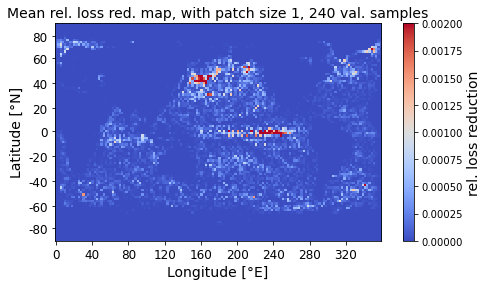

In [5]:
## range_0_100, relevance_1: TRAINING samples!
# Include 240 samples, 120 from both edges of the time line.
# patch_size = 1
# max_patch_num = 50
# max_acc_rel_loss_reduction = 0.9

# Compute mean of rel. loss reduction maps, over desired number of considered validation samples:
mean_rel_loss_reduction_map = np.mean(rel_loss_reduction_maps[:n_samples],axis=0)

# Plot resulting FLIPPED mean rel. loss reduction map as heatmap:        
fig, ax = plt.subplots(figsize=(8, 4))
im = plt.imshow(np.flip(mean_rel_loss_reduction_map,axis=0), cmap="coolwarm", interpolation='nearest', vmax=0.002)
cbar = plt.colorbar(im)
cbar.set_label('rel. loss reduction', fontsize=14)
plt.title('Mean rel. loss red. map, with patch size '+str(patch_size)+', '+str(n_samples)+' val. samples', fontsize=14)
plt.xlabel('Longitude [°E]', fontsize=14)
plt.ylabel('Latitude [°N]', fontsize=14)
plt.xticks(np.arange(0, 144, step=16), [0, 40, 80, 120, 160, 200, 240, 280, 320], fontsize=12)
plt.yticks([5, 15, 26, 37, 47, 58, 69, 80, 90], [80, 60, 40, 20, 0, -20, -40, -60, -80], fontsize=12)
plt.show()

In [11]:
# Get mask for invalid grid points (= land masses):
invalid_gridpoints = np.isnan(data[0])

In [14]:
# Copy mean rel. loss reduction map:
mean_rel_loss_reduction_map_nan = np.copy(mean_rel_loss_reduction_map)

# Set invalid grid points to NaN, to highlight land masses:
mean_rel_loss_reduction_map_nan[invalid_gridpoints] = float('nan')

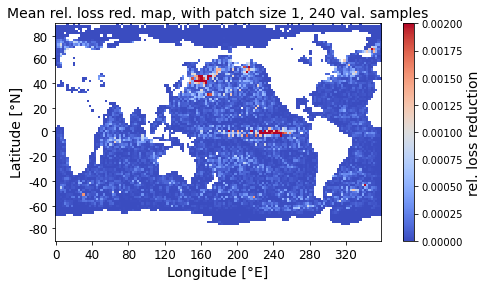

In [15]:
# Plot resulting FLIPPED mean rel. loss reduction map as heatmap:        
fig, ax = plt.subplots(figsize=(8, 4))
im = plt.imshow(np.flip(mean_rel_loss_reduction_map_nan,axis=0), cmap="coolwarm", interpolation='nearest', vmax=0.002)
cbar = plt.colorbar(im)
cbar.set_label('rel. loss reduction', fontsize=14)
plt.title('Mean rel. loss red. map, with patch size '+str(patch_size)+', '+str(n_samples)+' val. samples', fontsize=14)
plt.xlabel('Longitude [°E]', fontsize=14)
plt.ylabel('Latitude [°N]', fontsize=14)
plt.xticks(np.arange(0, 144, step=16), [0, 40, 80, 120, 160, 200, 240, 280, 320], fontsize=12)
plt.yticks([5, 15, 26, 37, 47, 58, 69, 80, 90], [80, 60, 40, 20, 0, -20, -40, -60, -80], fontsize=12)
plt.show()

/var/folders/jv/p__lpnd50w93ff78f84hkwkh7fs9_f/T/ipykernel_916/2380127889.py:5: RuntimeWarning: Mean of empty slice
  mean_acc_rel_loss_reduction = np.nanmean(acc_rel_loss_reductions[:n_samples],axis=0)


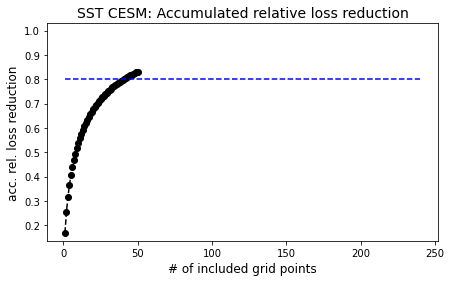

In [6]:
# Specify number of grid points to show on the x-axis of the plot:
n_gridpoints = 240

# Compute mean acc. rel. loss reduction, over desired number of considered validation samples:
mean_acc_rel_loss_reduction = np.nanmean(acc_rel_loss_reductions[:n_samples],axis=0)

# Plot mean acc. rel. loss reduction over desired number of patches to include:
fig, axes = plt.subplots(1,1,figsize=(7,4))

axes.plot(np.arange(0,n_gridpoints,step=1)+1, mean_acc_rel_loss_reduction[:n_gridpoints], color='black', marker='o', linestyle='--')
# Optionally add threshold:
axes.plot(np.arange(0,n_gridpoints,step=1)+1, np.ones(n_gridpoints)*0.8, color='blue', linestyle='--')

axes.set_ylim(top=1.03)
axes.set_title('SST CESM: Accumulated relative loss reduction', fontsize=14)
axes.set_xlabel('# of included grid points', fontsize=12)
axes.set_ylabel('acc. rel. loss reduction', fontsize=12)
#axes.legend()
plt.show() 

/tmp/ipykernel_1658189/3221499229.py:2: RuntimeWarning: Mean of empty slice
  mean_acc_rel_loss_reduction = np.nanmean(acc_rel_loss_reductions[:n_samples],axis=0)


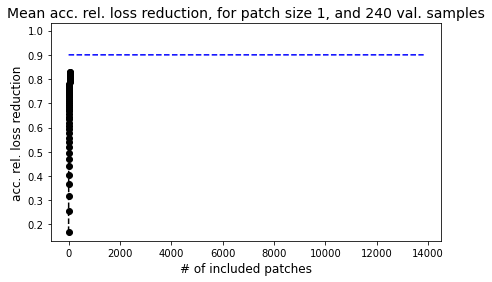

In [16]:
# Compute mean acc. rel. loss reduction, over desired number of considered validation samples:
mean_acc_rel_loss_reduction = np.nanmean(acc_rel_loss_reductions[:n_samples],axis=0)

# Plot mean acc. rel. loss reduction over desired number of patches to include:
fig, axes = plt.subplots(1,1,figsize=(7,4))

axes.plot(np.arange(0,n_patches,step=1)+1, mean_acc_rel_loss_reduction[:n_patches], color='black', marker='o', linestyle='--')
# Optionally add threshold:
axes.plot(np.arange(0,n_patches,step=1)+1, np.ones(n_patches)*0.9, color='blue', linestyle='--')

axes.set_ylim(top=1.03)
axes.set_title('Mean acc. rel. loss reduction, for patch size '+str(patch_size)+', and '+str(n_samples)+' val. samples', fontsize=14)
axes.set_xlabel('# of included patches', fontsize=12)
axes.set_ylabel('acc. rel. loss reduction', fontsize=12)
#axes.legend()
plt.show() 

### Clustering with GMM to find optimal masks

#### 99.9% missing

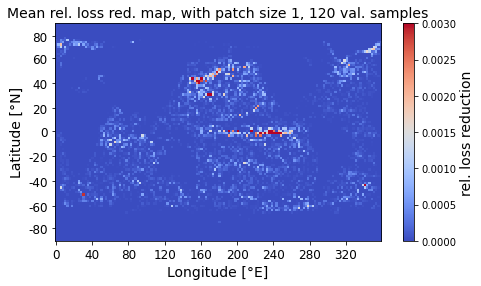

In [22]:
## range_0_100, relevance_1: TRAINING samples!
# Include first 120 samples, hence from the beginning of training data.
# patch_size = 1
# max_patch_num = 50
# max_acc_rel_loss_reduction = 0.9

# Compute mean of rel. loss reduction maps, over desired number of considered validation samples:
mean_rel_loss_reduction_map = np.mean(rel_loss_reduction_maps[:n_samples],axis=0)

# Plot resulting FLIPPED mean rel. loss reduction map as heatmap:        
fig, ax = plt.subplots(figsize=(8, 4))
im = plt.imshow(np.flip(mean_rel_loss_reduction_map,axis=0), cmap="coolwarm", interpolation='nearest', vmax=0.003)
cbar = plt.colorbar(im)
cbar.set_label('rel. loss reduction', fontsize=14)
plt.title('Mean rel. loss red. map, with patch size '+str(patch_size)+', '+str(n_samples)+' val. samples', fontsize=14)
plt.xlabel('Longitude [°E]', fontsize=14)
plt.ylabel('Latitude [°N]', fontsize=14)
plt.xticks(np.arange(0, 144, step=16), [0, 40, 80, 120, 160, 200, 240, 280, 320], fontsize=12)
plt.yticks([5, 15, 26, 37, 47, 58, 69, 80, 90], [80, 60, 40, 20, 0, -20, -40, -60, -80], fontsize=12)
plt.show()

In [23]:
# Look for number of grid points in mean rel. loss reduction map with non-zero entry:
print("non-zero entries in mean rel. loss reduction map: ", np.sum(mean_rel_loss_reduction_map!=0))

non-zero entries in mean rel. loss reduction map:  3423


In [38]:
## Start with 3D clustering of x/y positions and its rel. loss reduction (z) for non-zero entries:
## Optionally cut of noise in mean rel. loss reduction map:

# Set threshold:
noise_threshold = 0.001

# Compute max. rel. loss reduction, for scaling of z-component:
max_rel_loss_red = np.max(mean_rel_loss_reduction_map)

# Create tuples of x/y/z positions:
xyz = []

# Loop over longitude:
for x in range(n_lon):
    
    # Loop over latitude:
    for y in range(n_lat):
        
        # Check for non-zero entry in mean rel. loss reduction map:
        if mean_rel_loss_reduction_map[y,x] > noise_threshold:
            
#         # Alternatively check for grid points, that exceed threshold in patch_counts:
#         if patch_counts_2D[y,x] > 5:
            
            # Store xyz-tuple, scaled to [0,1] in either dimension:
            xyz.append([x/(n_lon-1), y/(n_lat-1), mean_rel_loss_reduction_map[y,x]/max_rel_loss_red])

# Convert list of xyz-tuples to np.array:
xyz = np.array(xyz)

# Output number of obtained tuples:
print("number of xyz-tuples representing non-zero entries in mean rel. loss reduction map: ", len(xyz))

number of xyz-tuples representing non-zero entries in mean rel. loss reduction map:  135


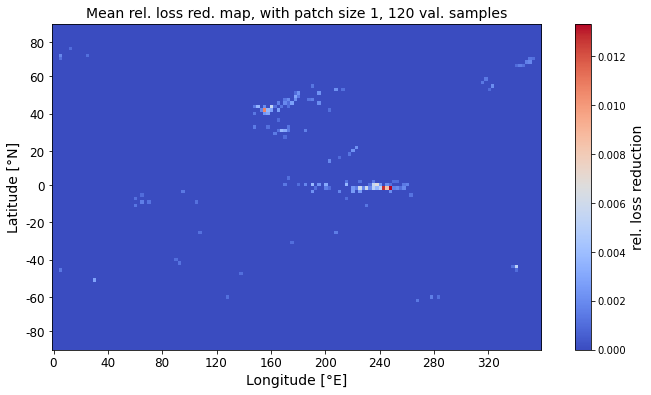

In [39]:
## Plot mean rel. loss reduction map, only grid points with value exceeding threshold, used to cut-off noise:
mean_rel_loss_reduction_map_cut = (mean_rel_loss_reduction_map>noise_threshold) * mean_rel_loss_reduction_map

# Plot resulting mean rel. loss reduction map with cut off noise as heatmap:        
fig, ax = plt.subplots(figsize=(12, 6))
im = plt.imshow(np.flip(mean_rel_loss_reduction_map_cut,axis=0), cmap="coolwarm", interpolation='nearest')#, vmax=0.002)
cbar = plt.colorbar(im)
cbar.set_label('rel. loss reduction', fontsize=14)
plt.title('Mean rel. loss red. map, with patch size '+str(patch_size)+', '+str(n_samples)+' val. samples', fontsize=14)
plt.xlabel('Longitude [°E]', fontsize=14)
plt.ylabel('Latitude [°N]', fontsize=14)
plt.xticks(np.arange(0, 144, step=16), [0, 40, 80, 120, 160, 200, 240, 280, 320], fontsize=12)
plt.yticks([5, 15, 26, 37, 47, 58, 69, 80, 90], [80, 60, 40, 20, 0, -20, -40, -60, -80], fontsize=12)
plt.show()

In [40]:
# Get clusters from GMM algorithms with pre-specified number of clusters = 14 (=0.1% for CESM sst grid).
# Note: Only use positional features (lat and lon), omit mean rel. loss reduction as feature:
GMM_999 = GaussianMixture(n_components=14, random_state=0).fit(xyz[:,:2])

# Get clusters:
GMM_999_clusters = GMM_999.predict(xyz[:,:2])

## Prepare colors for visualizing clusters:

# # Set colors:
# colors = ['red', 'orange', 'yellow', 'blue', 'pink', 'cyan', 'magenta', 'grey', 'brown', 'purple']

# # Create list of colors:
# GMM_colors = []
# for i in range(len(GMM_999_clusters)):
#     GMM_colors.append(colors[GMM_999_clusters[i]])

In [41]:
## Convert obtained cluster means to CESM lat/lon grid:

# Initialize storage:
cluster_means_999_GMM = np.zeros(GMM_999.means_.shape).astype(int)

# Unscale latitude and longitude dimensions:
cluster_means_999_GMM[:,0] = np.round(GMM_999.means_[:,0]*(n_lon-1),0).astype(int)
cluster_means_999_GMM[:,1] = np.round(GMM_999.means_[:,1]*(n_lat-1),0).astype(int)

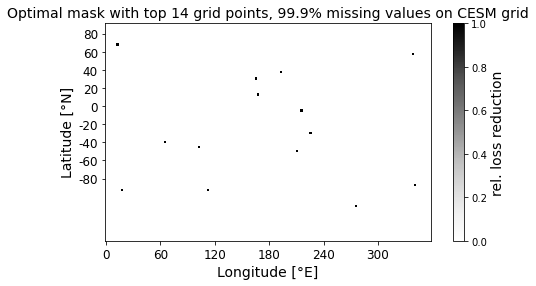

In [42]:
## Create optimal mask from cluster centers:

# Initialize two-dimensional boolean mask of FALSE, dimension (n_lat, n_lon):
mask_999_GMM = (np.zeros((n_lat,n_lon))!=0)

# Loop over cluster centers:
for xyz in cluster_means_999_GMM:
    
    # Set grid points to True:
    mask_999_GMM[xyz[1],xyz[0]]=True

# Plot optimal mask:
fig, ax = plt.subplots(figsize=(8, 4))
im = plt.imshow(np.flip(mask_999_GMM,axis=0), cmap="Greys", interpolation='nearest')#, vmax=0.00022)
cbar = plt.colorbar(im)
cbar.set_label('rel. loss reduction', fontsize=14)
plt.title('Optimal mask with top 14 grid points, 99.9% missing values on CESM grid', fontsize=14)
plt.xlabel('Longitude [°E]', fontsize=14)
plt.ylabel('Latitude [°N]', fontsize=14)
plt.xticks(np.arange(0, 144, step=24), [0, 60, 120, 180, 240, 300], fontsize=12)
plt.yticks(np.arange(4, 72, step=8), [80, 60, 40, 20, 0, -20, -40, -60, -80], fontsize=12)
plt.show()

In [43]:
# Set path to store optimal missing masks:
path_to_store_masks = Path(
    'GitGeomar/marco-landt-hayen/reconstruct_missing_data_results/'+model_config+'_'+feature_short+'_'+source+'_'+
    mask_type+'_'+missing_type+'_factor_'+str(augmentation_factor)+run+exp_name)

print(path_to_store_masks)

GitGeomar/marco-landt-hayen/reconstruct_missing_data_results/unet_4conv_sst_CESM_variable_range_0_100_factor_3_final/relevance_1


In [44]:
## Store masks, to re-use in batch:
#np.save(path_to_store_masks / "optimal_sampling_mask_999.npy", mask_999_GMM)

#### 99% missing

non-zero entries in mean rel. loss reduction map:  3423
noise threshold: 0.0005
number of xyz-tuples representing non-zero entries in mean rel. loss reduction map:  377


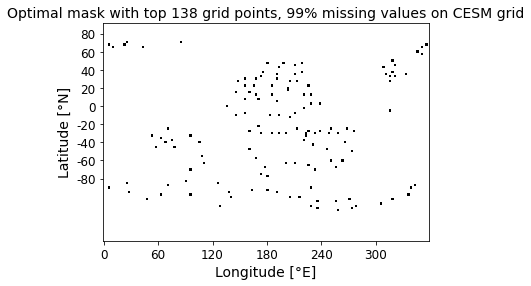

In [45]:
# Look for number of grid points in mean rel. loss reduction map with non-zero entry:
print("non-zero entries in mean rel. loss reduction map: ", np.sum(mean_rel_loss_reduction_map!=0))

## Start with 3D clustering of x/y positions and its rel. loss reduction (z) for non-zero entries:
## Optionally cut of noise in mean rel. loss reduction map:

# Set threshold:
noise_threshold = 0.0005

print('noise threshold:',noise_threshold)

# Compute max. rel. loss reduction, for scaling of z-component:
max_rel_loss_red = np.max(mean_rel_loss_reduction_map)

# Create tuples of x/y/z positions:
xyz = []

# Loop over longitude:
for x in range(n_lon):
    
    # Loop over latitude:
    for y in range(n_lat):
        
        # Check for non-zero entry in mean rel. loss reduction map:
        if mean_rel_loss_reduction_map[y,x] > noise_threshold:
            
#         # Alternatively check for grid points, that exceed threshold in patch_counts:
#         if patch_counts_2D[y,x] > 5:
            
            # Store xyz-tuple, scaled to [0,1] in either dimension:
            xyz.append([x/(n_lon-1), y/(n_lat-1), mean_rel_loss_reduction_map[y,x]/max_rel_loss_red])

# Convert list of xyz-tuples to np.array:
xyz = np.array(xyz)

# Output number of obtained tuples:
print("number of xyz-tuples representing non-zero entries in mean rel. loss reduction map: ", len(xyz))

# Get clusters from GMM algorithms with pre-specified number of clusters = 138 (=1% for CESM sst grid).
# Note: Only use positional features (lat and lon), omit mean rel. loss reduction as feature:
GMM_99 = GaussianMixture(n_components=138, random_state=0).fit(xyz[:,:2])

# Get clusters:
GMM_99_clusters = GMM_99.predict(xyz[:,:2])

## Convert obtained cluster means to CESM lat/lon grid:

# Initialize storage:
cluster_means_99_GMM = np.zeros(GMM_99.means_.shape).astype(int)

# Unscale latitude and longitude dimensions:
cluster_means_99_GMM[:,0] = np.round(GMM_99.means_[:,0]*(n_lon-1),0).astype(int)
cluster_means_99_GMM[:,1] = np.round(GMM_99.means_[:,1]*(n_lat-1),0).astype(int)

## Create optimal mask from cluster centers:

# Initialize two-dimensional boolean mask of FALSE, dimension (n_lat, n_lon):
mask_99_GMM = (np.zeros((n_lat,n_lon))!=0)

# Loop over cluster centers:
for xyz in cluster_means_99_GMM:
    
    # Set grid points to True:
    mask_99_GMM[xyz[1],xyz[0]]=True

# Plot optimal mask:
fig, ax = plt.subplots(figsize=(8, 4))
im = plt.imshow(np.flip(mask_99_GMM,axis=0), cmap="Greys", interpolation='nearest')#, vmax=0.00022)
#cbar = plt.colorbar(im)
#cbar.set_label('rel. loss reduction', fontsize=14)
plt.title('Optimal mask with top 138 grid points, 99% missing values on CESM grid', fontsize=14)
plt.xlabel('Longitude [°E]', fontsize=14)
plt.ylabel('Latitude [°N]', fontsize=14)
plt.xticks(np.arange(0, 144, step=24), [0, 60, 120, 180, 240, 300], fontsize=12)
plt.yticks(np.arange(4, 72, step=8), [80, 60, 40, 20, 0, -20, -40, -60, -80], fontsize=12)
plt.show()

In [46]:
# Set path to store optimal missing masks:
path_to_store_masks = Path(
    'GitGeomar/marco-landt-hayen/reconstruct_missing_data_results/'+model_config+'_'+feature_short+'_'+source+'_'+
    mask_type+'_'+missing_type+'_factor_'+str(augmentation_factor)+run+exp_name)

print(path_to_store_masks)

GitGeomar/marco-landt-hayen/reconstruct_missing_data_results/unet_4conv_sst_CESM_variable_range_0_100_factor_3_final/relevance_1


In [47]:
## Store masks, to re-use in batch:
#np.save(path_to_store_masks / "optimal_sampling_mask_99.npy", mask_99_GMM)

#### 95% missing

non-zero entries in mean rel. loss reduction map:  3423
noise threshold: 0.0
number of xyz-tuples representing non-zero entries in mean rel. loss reduction map:  3423


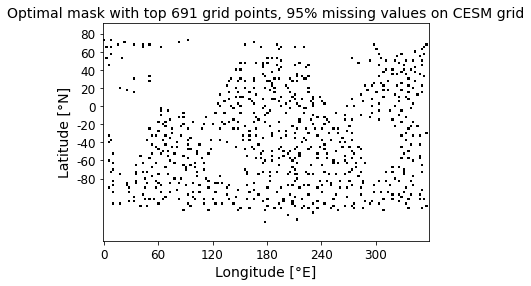

In [48]:
# Look for number of grid points in mean rel. loss reduction map with non-zero entry:
print("non-zero entries in mean rel. loss reduction map: ", np.sum(mean_rel_loss_reduction_map!=0))

## Start with 3D clustering of x/y positions and its rel. loss reduction (z) for non-zero entries:
## Optionally cut of noise in mean rel. loss reduction map:

# Set threshold:
noise_threshold = 0.0

print('noise threshold:',noise_threshold)

# Compute max. rel. loss reduction, for scaling of z-component:
max_rel_loss_red = np.max(mean_rel_loss_reduction_map)

# Create tuples of x/y/z positions:
xyz = []

# Loop over longitude:
for x in range(n_lon):
    
    # Loop over latitude:
    for y in range(n_lat):
        
        # Check for non-zero entry in mean rel. loss reduction map:
        if mean_rel_loss_reduction_map[y,x] > noise_threshold:
            
#         # Alternatively check for grid points, that exceed threshold in patch_counts:
#         if patch_counts_2D[y,x] > 5:
            
            # Store xyz-tuple, scaled to [0,1] in either dimension:
            xyz.append([x/(n_lon-1), y/(n_lat-1), mean_rel_loss_reduction_map[y,x]/max_rel_loss_red])

# Convert list of xyz-tuples to np.array:
xyz = np.array(xyz)

# Output number of obtained tuples:
print("number of xyz-tuples representing non-zero entries in mean rel. loss reduction map: ", len(xyz))

# Get clusters from GMM algorithms with pre-specified number of clusters = 691 (=5% for CESM sst grid).
# Note: Only use positional features (lat and lon), omit mean rel. loss reduction as feature:
GMM_95 = GaussianMixture(n_components=691, random_state=0).fit(xyz[:,:2])

# Get clusters:
GMM_95_clusters = GMM_95.predict(xyz[:,:2])

## Convert obtained cluster means to CESM lat/lon grid:

# Initialize storage:
cluster_means_95_GMM = np.zeros(GMM_95.means_.shape).astype(int)

# Unscale latitude and longitude dimensions:
cluster_means_95_GMM[:,0] = np.round(GMM_95.means_[:,0]*(n_lon-1),0).astype(int)
cluster_means_95_GMM[:,1] = np.round(GMM_95.means_[:,1]*(n_lat-1),0).astype(int)

## Create optimal mask from cluster centers:

# Initialize two-dimensional boolean mask of FALSE, dimension (n_lat, n_lon):
mask_95_GMM = (np.zeros((n_lat,n_lon))!=0)

# Loop over cluster centers:
for xyz in cluster_means_95_GMM:
    
    # Set grid points to True:
    mask_95_GMM[xyz[1],xyz[0]]=True

# Plot optimal mask:
fig, ax = plt.subplots(figsize=(8, 4))
im = plt.imshow(np.flip(mask_95_GMM,axis=0), cmap="Greys", interpolation='nearest')#, vmax=0.00022)
#cbar = plt.colorbar(im)
#cbar.set_label('rel. loss reduction', fontsize=14)
plt.title('Optimal mask with top 691 grid points, 95% missing values on CESM grid', fontsize=14)
plt.xlabel('Longitude [°E]', fontsize=14)
plt.ylabel('Latitude [°N]', fontsize=14)
plt.xticks(np.arange(0, 144, step=24), [0, 60, 120, 180, 240, 300], fontsize=12)
plt.yticks(np.arange(4, 72, step=8), [80, 60, 40, 20, 0, -20, -40, -60, -80], fontsize=12)
plt.show()

In [49]:
# Set path to store optimal missing masks:
path_to_store_masks = Path(
    'GitGeomar/marco-landt-hayen/reconstruct_missing_data_results/'+model_config+'_'+feature_short+'_'+source+'_'+
    mask_type+'_'+missing_type+'_factor_'+str(augmentation_factor)+run+exp_name)

print(path_to_store_masks)

GitGeomar/marco-landt-hayen/reconstruct_missing_data_results/unet_4conv_sst_CESM_variable_range_0_100_factor_3_final/relevance_1


In [50]:
## Store masks, to re-use in batch:
#np.save(path_to_store_masks / "optimal_sampling_mask_95.npy", mask_95_GMM)